# Exercise Sheet 6 - Regularization 2

In this exercise we will take a look at simple but effective methods used to combat overfitting when learning neural networks. We will use a very small subset of the FashionMNIST dataset to artificially induce overfitting, train and evaluate our model. Finally we will look at how to incorporate early stopping and how adding noise to our data makes our model more robust.

In [1]:
from typing import Callable
from functools import partial

import torch
from torch import nn
from torch.optim import Optimizer, SGD

from torchvision.transforms import v2

#from solution import *
from utils import *

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cpu'

# Training configuration

Throughout this notebook we will use the following training configuration:

In [2]:
TRAIN_SET_SIZE = 200
VAL_SET_SIZE = 1000
EPOCHS = 500
HIDDEN_DIMS = [64, 32]
LR = 0.05
BATCH_SIZE = 32

# Dataset (FashionMNIST)

As mentioned before, we will use the FashionMNIST dataset. This dataset behaves exactly the same as the standard MNIST dataset (grayscale images with height and width of 28 pixels, 10 classes (0-9), train set with 60k samples and test set with 10k samples) with the only difference being the depicted images. While MNIST shows handwritten digits, FashionMNIST shows 10 different types of clothing. Example images are shown after execution of the following cell.

/Users/yilongwang/anaconda3/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Shape of images is torch.Size([32, 1, 28, 28])


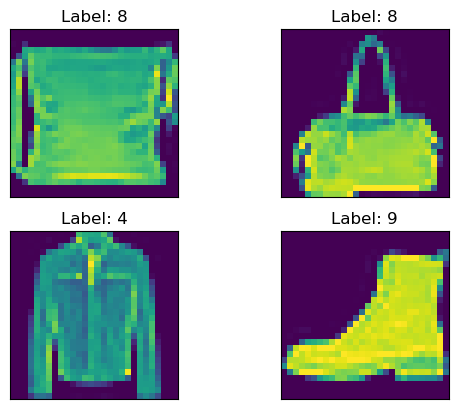

In [3]:
train_set, val_set, test_set = get_fashion_mnist_subset(TRAIN_SET_SIZE, VAL_SET_SIZE, transforms=v2.ToTensor())

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE)

visualize_first_4(train_loader)

# Create model

First, we need a function to create a model that is able to classify FashionMNIST data. The model takes in inputs of the shape (batch_size x 1 x 28 x 28) and outputs a 10-dimensional vector. It should first flatten the input images, then apply a given number of linear layers to it, and finally map to a 10-dimensional vector which will be used to predict which type of clothing it is.

## Task 1a) (20 P)

Complete the missing code in the following function. The function takes a list of hidden dimensions which correspond to the dimensionality of the linear layers. The input dimension of 28 x 28 and the output dimension of 10 should be hardcoded into the model. There should be as many layers as hidden dimensions, plus a final output layer. As an activation function we will use the ReLU activation.

In [4]:
def create_model(hidden_dims: list[int]):  # TODO: explain in docstring that input is written without brackets
    """Create a model that works for classifying the FahsionMNIST dataset."""
    # --------------------------------------------------
    # TODO: Replace by your code
    # --------------------------------------------------
    #model = solution_1a_create_model(hidden_dims)
    
    input_dim = 28*28
    output_dim = 10
    layers = []
    
    layers.append(nn.Flatten())
    layers.append(nn.Linear(input_dim,hidden_dims[0]))
    layers.append(nn.ReLU())
    
    for i in range(len(hidden_dims)-1):
        layers.append(nn.Linear(hidden_dims[i],hidden_dims[i+1]))
        layers.append(nn.ReLU())
        
    layers.append(nn.Linear(hidden_dims[-1],output_dim))
    model = nn.Sequential(*layers)
    
    
    # --------------------------------------------------

    model.to(DEVICE)
    return model


# Train, evaluate and save models

## Task 2a) (20 P)
Write a function that trains a model for one epoch / one iteration through the train dataset. Make sure to zero the gradients before each step and to apply the optimizers functions to train the model. This is a repetition from last exercise, so check there in case you are unsure.

In [5]:
def train_one_epoch(model, dataloader, optimizer):
    # --------------------------------------------------
    # TODO: Replace by your code
    # --------------------------------------------------
    #avg_loss = solution_2a_train_one_epoch(model, dataloader, optimizer)
    
    loss_fn = nn.CrossEntropyLoss()
    model.train()
    losses = []
    
    for X, y in dataloader:
        pred = model(X)
        loss = loss_fn(pred, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        losses.append(loss.item())
    
    avg_loss = sum(losses) / len(losses)
    
    # --------------------------------------------------
    return avg_loss

## Task 2b) (20 P)

Write a function that iterates through a dataloader, and outputs the average loss and accuracy. Make sure that no gradient computation is triggered, e.g. use [torch.no_grad()](https://pytorch.org/docs/stable/generated/torch.no_grad.html). Furthermore, make sure that your model in evaluation mode and to switch back afterwards. This will be important for the last task where we are adding Dropout layers to our neural network. For more information see [this](https://stackoverflow.com/questions/60018578/what-does-model-eval-do-in-pytorch) StackOverflow question.


In [6]:
def validate(model: nn.Module, dataloader: DataLoader) -> tuple[float, float]:
    # --------------------------------------------------
    # TODO: Replace by your code
    # --------------------------------------------------
    #avg_loss, avg_accuracy = solution_2b_evaluate(model, dataloader)
    
    loss_fn = nn.CrossEntropyLoss()
    losses = []
    correct_predict = 0
    number_samples = 0
    
    model.eval()
    with torch.no_grad():
        for X,y in dataloader:
            pred = model(X)
            loss = loss_fn(pred, y)
            losses.append(loss)
            
            _,predicted = torch.max(pred,1)
            correct_predict += sum(predicted == y)
            number_samples += len(y)
            
            

    avg_loss = sum(losses) / len(dataloader)     # number of batch
    avg_accuracy =  correct_predict / number_samples

    # --------------------------------------------------
    return avg_loss, avg_accuracy

Here we define our complete training function. It simply iterates for `n_epochs` epochs through the training dataset, evaluates after each epoch on the validation dataset, and finally returns an array with the train and validation losses for each epoch. An important feature of this training function is that it can take a function as an argument (that's the `callback` argument) which gets the model, the current epoch, the array of train losses up until this point, the array of validation losses until this point and the last validation accuracy. The follwing tasks will partly consist of writing functions that we will pass into the training function.

In [7]:
def train(
        model: nn.Module,
        train_loader: DataLoader,
        val_loader: DataLoader,
        optimizer: Optimizer,
        n_epochs: int,
        callback: Callable[[nn.Module, int, list[float], list[float], float], None]
    ) -> tuple[list[float], list[float]]:
    train_losses = []
    val_losses = []
    for epoch in range(n_epochs):
        train_loss = train_one_epoch(model, train_loader, optimizer)
        val_loss, val_acc = validate(model, val_loader)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        callback(model, epoch, train_losses, val_losses, val_acc)

    return train_losses, val_losses

## Task 2c) (10 P)

In this task you should simply write a function that we can pass into the training function above that prints the current stats every `n` epochs. This function shouldn't return anything.

In [8]:
def print_loss_every_n_epochs(
        model: nn.Module,
        epoch: int,
        train_losses: list[float],
        val_losses: list[float],
        val_acc,
        n: int) -> None:
    # --------------------------------------------------
    # TODO: Replace by your code
    # --------------------------------------------------
    #solution_2c_print_loss_every_n_epochs(
    #    model, epoch, train_losses, val_losses, val_acc, n)
    
    if epoch % n == 0:
        print(f"[EPOCH {epoch}] Train loss: {train_losses[-1]:.4f}, Validation loss: {val_losses[-1]:.4f}, Validation accuracy: {val_acc:.4f}")
    
    
    # --------------------------------------------------

Next we will train a model. We will use the above defined hyperparameters, and a simple SGD optimizer. Furthermore we will print the training stats every epoch.

[EPOCH 0] Train loss: 2.3145, Validation loss: 2.2877, Validation accuracy: 0.1360
[EPOCH 1] Train loss: 2.2902, Validation loss: 2.2701, Validation accuracy: 0.1800
[EPOCH 2] Train loss: 2.2525, Validation loss: 2.2500, Validation accuracy: 0.2270
[EPOCH 3] Train loss: 2.2336, Validation loss: 2.2221, Validation accuracy: 0.3070
[EPOCH 4] Train loss: 2.1828, Validation loss: 2.1871, Validation accuracy: 0.3670
[EPOCH 5] Train loss: 2.1180, Validation loss: 2.1361, Validation accuracy: 0.3870
[EPOCH 6] Train loss: 1.9704, Validation loss: 2.1136, Validation accuracy: 0.2870
[EPOCH 7] Train loss: 1.9365, Validation loss: 1.9819, Validation accuracy: 0.3440
[EPOCH 8] Train loss: 1.8460, Validation loss: 1.9070, Validation accuracy: 0.3620
[EPOCH 9] Train loss: 1.7293, Validation loss: 1.8045, Validation accuracy: 0.3770


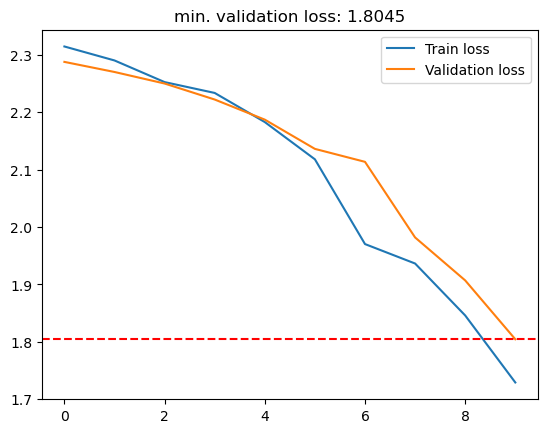

In [9]:
model = create_model(HIDDEN_DIMS)
optimizer = SGD(model.parameters(), lr=LR)

train_losses , val_losses = train(model,
                                   train_loader,
                                   val_loader,
                                   optimizer,
                                   n_epochs=10,
                                   callback=partial(print_loss_every_n_epochs, n=1))

plot_train_and_val_loss(train_losses, val_losses, title=f"min. validation loss: {min(val_losses):.4f}")

# Early stopping

Early stopping is the most simple thing to prevent your final model to overfit: you simply track train and test errors and use a model checkpoint before your model started to overfit.

## Task 3a) (10 P)

Implementing early stopping is pretty straight forward. Simply save your model each time you've reached a new best validation loss, and otherwise don't. To reduce clutter in your filesystem you can simply override the saved model each time. Saving and loading PyTorch models is described in [this guide](https://pytorch.org/tutorials/beginner/saving_loading_models.html). The function to load models is given.

In [10]:
def save_model_if_improved(model, epoch, train_losses, val_losses, val_acc, filename):
    # --------------------------------------------------
    # TODO: Replace by your code
    # --------------------------------------------------
    #solution_3b_save_model_if_improved(model, epoch, train_losses, val_losses, val_acc, filename)
    if epoch == 0 or val_losses[-1] < min(val_losses[:-1]):
        torch.save(model.state_dict(), filename)
        print(f"[EPOCH {epoch}] Model saved with validation loss: {val_losses[-1]:.4f}")

    # --------------------------------------------------

def load_model(model, model_file_path: str) -> nn.Module:
    model.load_state_dict(torch.load(model_file_path, weights_only=True))
    return model

This time we will train our model for more epochs, to show how it overfits. Your implemented function should stop saving the model once the model starts to overfit.

In [ ]:
model = create_model(HIDDEN_DIMS)
optimizer = SGD(model.parameters(), lr=LR)
train_losses, val_losses = train(model,
                                train_loader,
                                val_loader,
                                optimizer,
                                n_epochs=EPOCHS,
                                callback=partial(save_model_if_improved, filename="early_stopping.pth"))

plot_train_and_val_loss(train_losses, val_losses, title=f"min. validation loss: {min(val_losses):.4f}")

We now evaluate our model on the test set, to get a better estimate of the generalization error. As you can see we've named the model

In [ ]:
pretrained_model = create_model(HIDDEN_DIMS)
load_model(pretrained_model, model_file_path="early_stopping.pth")
test_loss, test_accuracy = validate(pretrained_model, test_loader)

print(f"Early stopping model achieved test loss of {test_loss:.4f} and accuarcy {test_accuracy:.4f}")
# Early stopping model achieved test loss of 0.7912 and accuarcy 0.7292


# Dropout

Dropout is a technique where neurons are randoml set to zero, which introduces noise into the network, and helps to generalize better. Details are described in [this blogpost](https://towardsdatascience.com/dropout-in-neural-networks-47a162d621d9).

## Task 4a) (20 P)

Implement a function similar to the one above where we build a standard feed forward network. But now, after each activation layer, add a [nn.Dropout()](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html) layer with the dropout probability specified in the parameter `p`.

In [ ]:
def create_model_with_dropout(hidden_dims: list[int], p: float):
    # --------------------------------------------------
    # TODO: Replace by your code
    # --------------------------------------------------
    # model = solution_4a_create_model_with_dropout(hidden_dims, p)
    
    input_dim = 28*28
    output_dim = 10
    layers = []
    
    layers.append(nn.Flatten())
    layers.append(nn.Linear(input_dim,hidden_dims[0]))
    layers.append(nn.ReLU())
    layers.append(nn.Dropout(p))
    
    for i in range(len(hidden_dims)-1):
        layers.append(nn.Linear(hidden_dims[i],hidden_dims[i+1]))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(p))
        
    layers.append(nn.Linear(hidden_dims[-1],output_dim))
    model = nn.Sequential(*layers)
    
    # --------------------------------------------------

    model.to(DEVICE)
    return model

Next we will train a neural network with the exact same parameters as above, only that we now have added dropout layers.

In [ ]:
DROPOUT = 0.8

model = create_model_with_dropout(HIDDEN_DIMS, p=DROPOUT)
optimizer = SGD(model.parameters(), lr=LR)

train_losses, val_losses = train(model,
                                train_loader,
                                val_loader,
                                optimizer,
                                n_epochs=EPOCHS,
                                callback=partial(save_model_if_improved, filename="dropout.pth"))

plot_train_and_val_loss(train_losses, val_losses, title=f"min. validation loss: {min(val_losses):.4f}")

In [ ]:
pretrained_model = create_model_with_dropout(HIDDEN_DIMS, DROPOUT)
load_model(pretrained_model, "dropout.pth")
test_loss, test_accuracy = validate(pretrained_model, test_loader)

print(f"Dropout model achieved test loss of {test_loss:.4f} and accuracy of {test_accuracy:.4f}")
#Dropout model achieved test loss of 1.0192 and accuracy of 0.6272
